# CSTR Temperature Anomaly Detection with Rolling 3σ Rule

## Task
Analyze simulated reactor temperature data to identify trends and anomalies, mimicking chemical plant monitoring.

Download the free "Chemical Reactor Dataset" from Kaggle or generate synthetic data using NumPy (e.g., normal distribution for temperatures over time). Use Pandas to load/clean the CSV (handle missing values with fillna(), resample hourly data), NumPy for statistics (np.mean(), np.std() on temperature arrays), and Matplotlib for line plots of temperature vs. time plus histograms of deviations. 

Key tasks: 
- Compute rolling averages
- detect outliers (>3σ)
- and plot efficiency metrics

In [197]:
#Importing the big three
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_We now fix the problem statement of ours_

* Generate data for 24 hours at a frequency of 1‑min for the reactor temperature, with NumPy, add realistic noise and a few fault periods, load with Pandas, compute rolling mean/std, detect >3σ outliers, and visualize with Matplotlib

In [198]:
np.random.seed(0)# So that we get this data again in case we have to run it:-reproducibility

#24 hrs at one minute frequence
time_index=pd.date_range(start='2025-01-01 00:00:00',periods=24*60,freq='min')#Takes a measurement after 1 min for next 24*60 time periods.
# Now setting the base data from the reactor to be gaussian using numpy's normal distribution
T_base=np.random.normal(loc=350,scale=2,size=len(time_index))
df=pd.DataFrame({'timestamp':time_index,'T_reactor':T_base}).set_index('timestamp')
#Dataset has been generated.

In [199]:
#EDA
df.head()

,T_reactor
timestamp,
2025-01-01 00:00:00,353.528105
2025-01-01 00:01:00,350.800314
2025-01-01 00:02:00,351.957476
2025-01-01 00:03:00,354.481786
2025-01-01 00:04:00,353.735116


In [200]:
df.tail()

,T_reactor
timestamp,
2025-01-01 23:55:00,351.872215
2025-01-01 23:56:00,351.618361
2025-01-01 23:57:00,347.603814
2025-01-01 23:58:00,350.813314
2025-01-01 23:59:00,352.403396


In [201]:
df.describe()

,T_reactor
count,1440.000000
mean,349.955278
std,1.965090
min,343.907714
25%,348.625133
50%,349.930663
75%,351.229349
max,356.341950


In [202]:
print(df.shape)

(1440, 1)


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2025-01-01 00:00:00 to 2025-01-01 23:59:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   T_reactor  1440 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


In [204]:
df.columns

Index(['T_reactor'], dtype='object')

Now we make the data messy

In [205]:
#Now we make the faulty dataset
df_faulty=df.copy()# Copied the perfect one

#Lets define fault windows now.--like burst errors
# 1) From 05:00 to 05:30
fault1_start="2025-01-01 05:00:00"
fault1_end='2025-01-01 05:30:00'

#2) From 16:15 to 16:45
fault2_start="2025-01-01 16:15:00"
fault2_end='2025-01-01 16:45'

#Adding +10 in the faults
df_faulty.loc[fault1_start:fault1_end,'T_reactor']+=10
df_faulty.loc[fault2_start:fault2_end,'T_reactor']+=10

#Adding a column for locating the true fault regions for later comparisons
df_faulty['true_fault']=False
df_faulty.loc[fault1_start:fault1_end,'true_fault']=True
df_faulty.loc[fault2_start:fault2_end,'true_fault']=True

In [206]:
#Insert some missing values within the dataset.
df_faulty['T_reactor_original']=df_faulty['T_reactor']#Keeping a copy of the temperature in another column

n=len(df_faulty)#Total length
n_missing=int(0.02*n) #2% of data gonna miss

missing_indices=np.random.choice(n,size=n_missing,replace=False)
#numpy.random.choice(a, size=None, replace=True, p=None)- a takes an integer and does np.arang(a), p takes the PMF and replace asks if it has to
#choose values with replacement or without it.As whole, fn chooses size values out of n-the list provided.
df_faulty.iloc[missing_indices,df_faulty.columns.get_loc("T_reactor")]=np.nan
#Cant use loc because we removed indexing in the dataframe
#Cant use only T_reactor as strings are not supported by iloc, so using its location

print(df_faulty.isna().sum())
df_faulty.head()

T_reactor             28
true_fault             0
T_reactor_original     0
dtype: int64


,T_reactor,true_fault,T_reactor_original
timestamp,,,
2025-01-01 00:00:00,353.528105,False,353.528105
2025-01-01 00:01:00,350.800314,False,350.800314
2025-01-01 00:02:00,351.957476,False,351.957476
2025-01-01 00:03:00,354.481786,False,354.481786
2025-01-01 00:04:00,353.735116,False,353.735116


In [207]:
print(df_faulty.loc['2025-01-01 05:00:00':'2025-01-01 05:30:00'])

                      T_reactor  true_fault  T_reactor_original
timestamp                                                      
2025-01-01 05:00:00  357.386946        True          357.386946
2025-01-01 05:01:00  363.316261        True          363.316261
2025-01-01 05:02:00  359.763672        True          359.763672
2025-01-01 05:03:00  358.639644        True          358.639644
2025-01-01 05:04:00  361.332766        True          361.332766
2025-01-01 05:05:00  359.078560        True          359.078560
2025-01-01 05:06:00  357.331483        True          357.331483
2025-01-01 05:07:00  357.306565        True          357.306565
2025-01-01 05:08:00  361.387546        True          361.387546
2025-01-01 05:09:00  359.680853        True          359.680853
2025-01-01 05:10:00  359.732597        True          359.732597
2025-01-01 05:11:00  362.155488        True          362.155488
2025-01-01 05:12:00  357.746348        True          357.746348
2025-01-01 05:13:00  358.538644        T

In [208]:
df_clean = df_faulty.copy()

#df_clean=df_clean.fillna(df_clean.mean())
#My way
#print(df_clean.loc['2025-01-01 05:00:00':'2025-01-01 05:30:00'])

#Interpolating NaNs in T_reactors using time/index based interpolation
df_clean['T_reactor']=df_clean['T_reactor'].interpolate(method='time')# Method linear does linear interpolation
#Method Time is for time series data that interpolates based on a time weighted average
#To fill any other value that might have been left due to default settings.

df_clean['T_reactor']=df_clean['T_reactor'].fillna(method='bfill').fillna(method='ffill')
print(df_clean.isna().sum())#For checking

T_reactor             0
true_fault            0
T_reactor_original    0
dtype: int64


C:\Users\suraj\AppData\Local\Temp\ipykernel_11420\2941425550.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean['T_reactor']=df_clean['T_reactor'].fillna(method='bfill').fillna(method='ffill')


In [209]:
#Rolling mean and std

#Set a window of 60 minutes
window=60
df_clean['T_roll_mean']=df_clean['T_reactor'].rolling(window=window,min_periods=30).mean()
#Rolling takes a window above the current point and checks the statistic for that data and assigns it
df_clean['T_roll_std']=df_clean['T_reactor'].rolling(window=window,min_periods=30).std()
df_clean['T_dev']=df_clean['T_reactor']-df_clean['T_roll_mean']
#df_clean
#Here for 29 first values, no stat is calculated since they donot have min period of 30 before them, but 29th element has it including himself

In [210]:
threshold=3# For sigma

df_clean['is_outlier']=False
#Mask valid is a criterion for if we are going to proceed with df clean.
mask_valid=df_clean['T_roll_std'].notna()#Avoid first window NaNs- by setting their values as False
#df_clean.loc[mask_valid,'is_outlier'] lets me access the value only if mask_valid is true
df_clean.loc[mask_valid,'is_outlier']=(
    df_clean.loc[mask_valid,'T_dev'].abs()>threshold*df_clean.loc[mask_valid, "T_roll_std"])
#Updated if outlier

#Finding false outlier
false_outliers = df_clean.query("true_fault == False and is_outlier == True")

print(df_clean['is_outlier'].value_counts())
print(false_outliers)

is_outlier
False    1433
True        7
Name: count, dtype: int64
                      T_reactor  true_fault  T_reactor_original  T_roll_mean  \
timestamp                                                                      
2025-01-01 22:31:00  355.285871       False          355.285871   349.723681   

                     T_roll_std    T_dev  is_outlier  
timestamp                                             
2025-01-01 22:31:00    1.713917  5.56219        True  


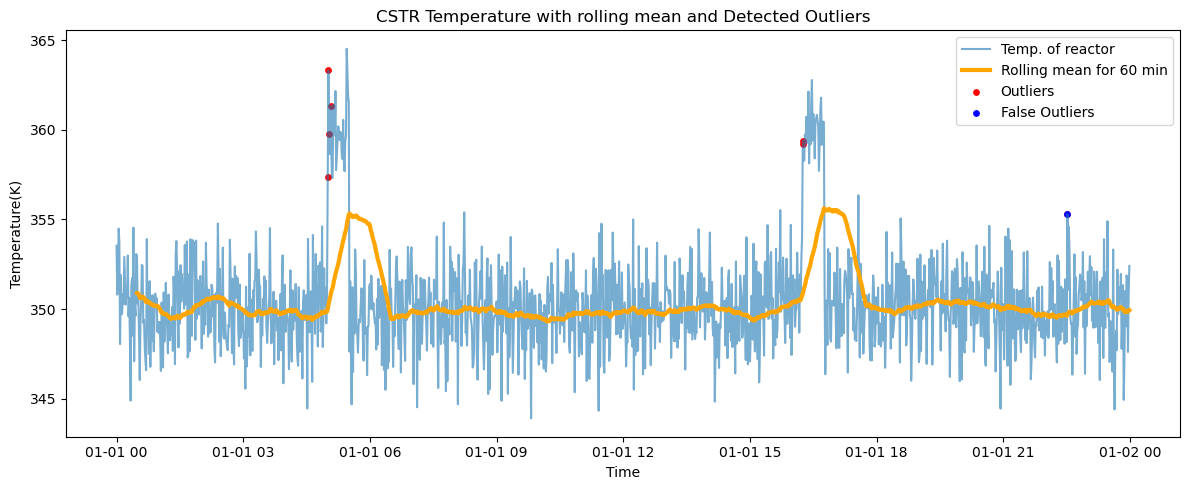

In [211]:
#PLotting
plt.figure(figsize=(12,5))
plt.plot(df_clean.index,df_clean["T_reactor"],label='Temp. of reactor',alpha=0.6)
plt.plot(df_clean.index,df_clean['T_roll_mean'],label='Rolling mean for 60 min',color='orange',linewidth=3)

# Highlight outliers
outliers=df_clean[df_clean['is_outlier']==True]
plt.scatter(outliers.index,outliers['T_reactor'],color='red',label='Outliers',s=15)
plt.scatter(false_outliers.index,false_outliers['T_reactor'],color='blue',label='False Outliers',s=15)

#Labelling plot
plt.xlabel('Time')
plt.ylabel('Temperature(K)')
plt.title('CSTR Temperature with rolling mean and Detected Outliers')
plt.legend()
plt.tight_layout()
plt.show()

In [212]:
#Quantifying the goodness of our detector
tp=((df_clean['true_fault']==True) & (df_clean['is_outlier']==True)).sum()
fp=((df_clean['true_fault']==False) & (df_clean['is_outlier']==True)).sum()
tn=((df_clean['true_fault']==False) & (df_clean['is_outlier']==False)).sum()
fn=((df_clean['true_fault']==True) & (df_clean['is_outlier']==False)).sum()

print('TP:',tp,' FP:',fp,' TN:',tn,' FN:',fn)
precision=tp/(tp+fp) if tp+fp>0 else 0
recall=tp/(tp+fn) if tp+fn>0 else 0

print("Precision:", precision)# Precision gives the no of true outliers out of all those detected
print("Recall:", recall)# Recall gives the ratio of the no of outliers that we detected

TP: 6  FP: 1  TN: 1377  FN: 56
Precision: 0.8571428571428571
Recall: 0.0967741935483871


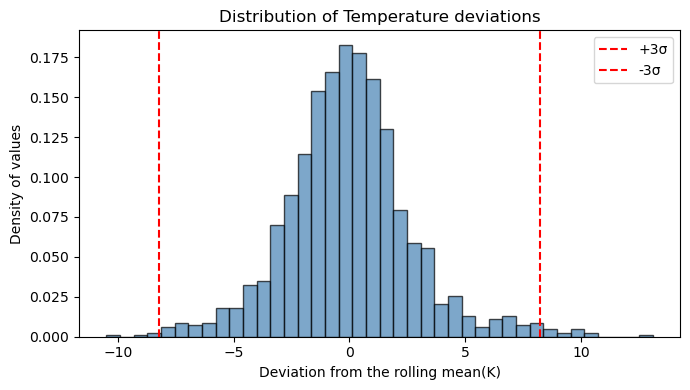

In [213]:
#Histograms of deviations with +-3 sigma
# Use only rows with valid rolling stats

valid=df_clean["T_roll_std"].notna()
dev = df_clean.loc[valid,'T_dev']

plt.figure(figsize=(7,4))
plt.hist(dev,bins=40,alpha=0.7,color='steelblue',density='True',edgecolor='black')
sigma=dev.std()# The standard deviation of the plotted data.

plt.axvline(+3*sigma,color='red',linestyle='--',label='+3σ')
plt.axvline(-3*sigma,color='red',linestyle='--',label='-3σ')
plt.xlabel('Deviation from the rolling mean(K)')
plt.ylabel('Density of values')
plt.title('Distribution of Temperature deviations')
plt.legend()
plt.tight_layout()
plt.show()

In [214]:
#Simple 'Efficiency'/Stability metrics- for putting in report later on.
n_total=len(df_clean)
n_fault_points=df_clean['true_fault'].sum()
n_outliers=df_clean['is_outlier'].sum()

print('Total Points:',n_total)
print('Fault points(true_fault=true):',n_fault_points)
print('Detected outliers:',n_outliers)
print("Outlier rate (%):", 100 * n_outliers / n_total)

# Fraction of fault points detected
detected_fault_fraction = tp / n_fault_points if n_fault_points > 0 else 0
print("Fraction of fault points detected:(Recall)", detected_fault_fraction)

Total Points: 1440
Fault points(true_fault=true): 62
Detected outliers: 7
Outlier rate (%): 0.4861111111111111
Fraction of fault points detected:(Recall) 0.0967741935483871


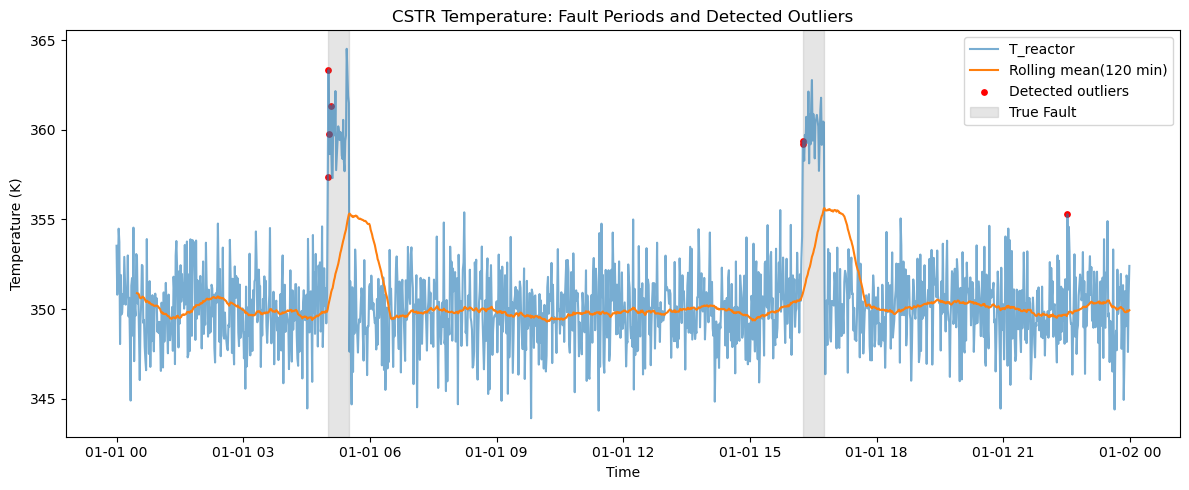

Precision: 0.86
Recall: 0.10
Outlier rate: 0.49%
Fraction of fault points detected: 0.10


In [215]:
plt.figure(figsize=(12,5))

# Main signal+ rolling mean
plt.plot(df_clean.index,df_clean['T_reactor'],label='T_reactor',alpha=0.6)
plt.plot(df_clean.index,df_clean['T_roll_mean'],label='Rolling mean(120 min)')

#Outliers
outliers=df_clean[df_clean['is_outlier']]
plt.scatter(outliers.index,outliers['T_reactor'],color='Red',s=15,label='Detected outliers')

# Shade true fault windows
for start,end in [("2025-01-01 05:00:00", "2025-01-01 05:30:00"),
                   ("2025-01-01 16:15:00", "2025-01-01 16:45:00")]:
    plt.axvspan(start,end,color='grey',alpha=0.2, label='True Fault')

#Dont want true fault to appear twice in legend- remove duplicate values:-
handles, labels = plt.gca().get_legend_handles_labels()
#plt.getcurrentaxes
#handles → graphical objects (lines, markers, bars, etc.)
#labels → text shown in the legend
#You get both of them and zip them-that is one value of label is mapped to the corresponding value of handle and a dict is made where only one value
# of the duplicates is retained.
unique=dict(zip(labels,handles))
plt.legend(unique.values(),unique.keys())

plt.xlabel("Time")
plt.ylabel("Temperature (K)")
plt.title("CSTR Temperature: Fault Periods and Detected Outliers")
plt.tight_layout()
plt.show()

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Outlier rate: {100 * n_outliers / n_total:.2f}%")
print(f"Fraction of fault points detected: {detected_fault_fraction:.2f}")